In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.dates as mdates

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_all = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Currency Exchange Rate Prediction/assets/data_JPY.csv', index_col = 'Date')
#data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Currency Exchange Rate Prediction/assets/data_stock_20.csv', index_col = 'Date')

data_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2583 entries, 30-01-2014 to 29-12-2023
Data columns (total 45 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bull_bear         2583 non-null   int64  
 1   Open              2583 non-null   float64
 2   High              2583 non-null   float64
 3   Low               2583 non-null   float64
 4   Close             2583 non-null   float64
 5   Adj Close         2583 non-null   float64
 6   Volume            2583 non-null   int64  
 7   EURUSD            2583 non-null   float64
 8   GBPUSD            2583 non-null   float64
 9   AUDUSD            2583 non-null   float64
 10  NZDUSD            2583 non-null   float64
 11  EURJPY            2583 non-null   float64
 12  GBPJPY            2583 non-null   float64
 13  CNY               2583 non-null   float64
 14  HKD               2583 non-null   float64
 15  SGD               2583 non-null   float64
 16  INR               2583 non-null 

In [4]:
#data = data[['bull_bear','Open','High','Low','Close','Adj Close','Volume','EURUSD','GBPUSD','AUDUSD','NZDUSD','EURJPY','GBPJPY','CNY','HKD','SGD','INR','pct_change','log_change','7ma','14ma','21ma','7macd','14macd','7rsi','14rsi','21rsi','7atr','14atr','21atr','7upper','7lower','14upper','14lower','21upper','21lower','7rsv','14rsv','21rsv','FT_3components','FT_6components','FT_9components','FT_27components','FT_81components','FT_100components']]
data = data_all[['bull_bear','Open','High','Low','Close','Adj Close','Volume','EURJPY','GBPJPY']]
#data = data_all[['bull_bear','Open','High','Low','Close','Adj Close','Volume','EURUSD','GBPUSD','AUDUSD','NZDUSD']]



In [5]:
data = data.iloc[:2583 , :]

data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()
#data = data.reset_index()
data.info()
data.head()


<class 'pandas.core.frame.DataFrame'>
Index: 2583 entries, 30-01-2014 to 29-12-2023
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   bull_bear  2583 non-null   int64  
 1   Open       2583 non-null   float64
 2   High       2583 non-null   float64
 3   Low        2583 non-null   float64
 4   Close      2583 non-null   float64
 5   Adj Close  2583 non-null   float64
 6   Volume     2583 non-null   int64  
 7   EURJPY     2583 non-null   float64
 8   GBPJPY     2583 non-null   float64
dtypes: float64(7), int64(2)
memory usage: 201.8+ KB


,bull_bear,Open,High,Low,Close,Adj Close,Volume,EURJPY,GBPJPY
Date,,,,,,,,,
30-01-2014,1,102.239998,102.779999,102.087997,102.300003,102.300003,0,139.712997,169.369003
31-01-2014,1,102.727997,102.907997,102.014999,102.758003,102.758003,0,139.315994,169.500000
03-02-2014,0,102.237999,102.393997,101.255997,102.192001,102.192001,0,137.828003,167.949997
04-02-2014,0,101.156998,101.567001,100.783997,101.141998,101.141998,0,136.770004,164.938995
05-02-2014,1,101.669998,101.671997,100.820999,101.689003,101.689003,0,137.440002,166.052994


In [6]:
col=data.shape[1]

In [7]:
data['y'] = data['Close']

x = data.iloc[:, :col].values
y = data.iloc[:, col].values

print(x)

[[  1.        102.2399979 102.7799988 ...   0.        139.7129974
  169.3690033]
 [  1.        102.7279968 102.9079971 ...   0.        139.3159943
  169.5      ]
 [  0.        102.237999  102.3939972 ...   0.        137.8280029
  167.9499969]
 ...
 [  0.        142.4609985 142.8320007 ...   0.        157.2949982
  181.2630005]
 [  0.        141.3990021 141.6519928 ...   0.        157.0630035
  180.9499969]
 [  0.        141.4299927 141.8990021 ...   0.        156.5269928
  180.0410004]]


In [8]:

split = int(data.shape[0]* 0.7)
train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))


train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

trainX: (1808, 9) trainY: (1808,)
testX: (775, 9) testY: (775,)


In [9]:
class VAE(nn.Module):
    def __init__(self, config, latent_dim):
        super().__init__()

        modules = []
        for i in range(1, len(config)):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i - 1], config[i]),
                    nn.ReLU()
                )
            )

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(config[-1], latent_dim)
        self.fc_var = nn.Linear(config[-1], latent_dim)

        modules = []
        self.decoder_input = nn.Linear(latent_dim, config[-1])

        for i in range(len(config) - 1, 1, -1):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i], config[i - 1]),
                    nn.ReLU()
                )
            )
        modules.append(
            nn.Sequential(
                nn.Linear(config[1], config[0]),
                nn.Sigmoid()
            )
        )

        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        logVar = self.fc_var(result)
        return mu, logVar

    def decode(self, x):
        result = self.decoder(x)
        return result

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5* logVar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        output = self.decode(z)
        return output, z, mu, logVar

In [10]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
#model = VAE([44, 400, 400, 400, 10], 10)
model = VAE([col, 400, 400, 400, 10], 10)

[1/300] Loss: 476.8497414588928
[2/300] Loss: 442.88207960128784
[3/300] Loss: 416.6677179336548
[4/300] Loss: 392.42618322372437
[5/300] Loss: 381.08278608322144
[6/300] Loss: 384.687949180603
[7/300] Loss: 384.85924100875854
[8/300] Loss: 370.92712354660034
[9/300] Loss: 358.18445897102356
[10/300] Loss: 353.1032838821411
[11/300] Loss: 352.24136090278625
[12/300] Loss: 347.55922746658325
[13/300] Loss: 339.7042832374573
[14/300] Loss: 331.4285271167755
[15/300] Loss: 325.9794542789459
[16/300] Loss: 325.01484966278076
[17/300] Loss: 325.2471139431
[18/300] Loss: 320.82082891464233
[19/300] Loss: 311.44165897369385
[20/300] Loss: 303.5751197338104
[21/300] Loss: 301.44640731811523
[22/300] Loss: 302.9741463661194
[23/300] Loss: 303.194020986557
[24/300] Loss: 299.02052783966064
[25/300] Loss: 291.1364531517029
[26/300] Loss: 282.4106080532074
[27/300] Loss: 275.1415615081787
[28/300] Loss: 270.6147439479828
[29/300] Loss: 269.5094151496887
[30/300] Loss: 271.52337193489075
[31/300] L

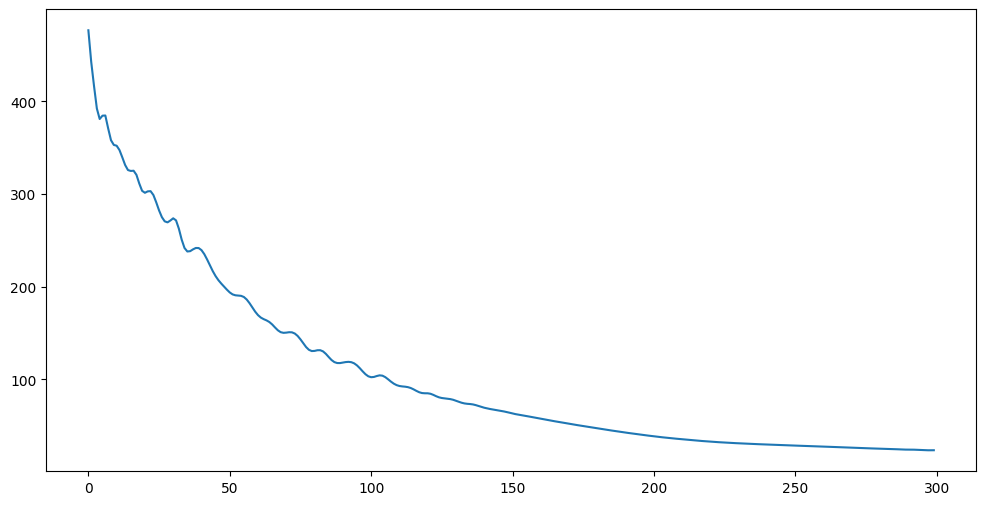

In [11]:

use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
num_epochs = 300
learning_rate = 0.00003
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs)
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)


In [12]:
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device))
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float().to(device))

In [13]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

In [14]:
train_x = np.concatenate((train_x, VAE_train_x.cpu().detach().numpy()), axis = 1)
test_x = np.concatenate((test_x, VAE_test_x.cpu().detach().numpy()), axis = 1)

In [15]:
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, 3)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([1805, 3, 19]) train_y: torch.Size([1805, 1]) train_y_gan: torch.Size([1805, 4, 1])
test_x: torch.Size([772, 3, 19]) test_y: torch.Size([772, 1]) test_y_gan: torch.Size([772, 4, 1])


In [16]:
size_col=train_x_slide.shape[2]


In [17]:
# WGAN
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru_1 = nn.GRU(input_size, 1024, batch_first = True)
        self.gru_2 = nn.GRU(1024, 512, batch_first = True)
        self.gru_3 = nn.GRU(512, 256, batch_first = True)
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)


    def forward(self, x):
        use_cuda = 1
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        h0 = torch.zeros(1, x.size(0), 1024).to(device)
        out_1, _ = self.gru_1(x, h0)
        out_1 = self.dropout(out_1)
        h1 = torch.zeros(1, x.size(0), 512).to(device)
        out_2, _ = self.gru_2(out_1, h1)
        out_2 = self.dropout(out_2)
        h2 = torch.zeros(1, x.size(0), 256).to(device)
        out_3, _ = self.gru_3(out_2, h2)
        out_3 = self.dropout(out_3)
        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out_6 = self.linear_3(out_5)
        return out_6

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size = 5, stride = 1, padding = 'same')
        self.conv2 = nn.Conv1d(32, 64, kernel_size = 5, stride = 1, padding = 'same')
        self.conv3 = nn.Conv1d(64, 128, kernel_size = 5, stride = 1, padding = 'same')
        self.linear1 = nn.Linear(128, 220)
        self.linear2 = nn.Linear(220, 220)
        self.linear3 = nn.Linear(220, 1)
        self.leaky = nn.LeakyReLU(0.01)
        self.relu = nn.ReLU()

    def forward(self, x):
        conv1 = self.conv1(x)
        conv1 = self.leaky(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.leaky(conv2)
        conv3 = self.conv3(conv2)
        conv3 = self.leaky(conv3)
        flatten_x =  conv3.reshape(conv3.shape[0], conv3.shape[1])
        out_1 = self.linear1(flatten_x)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out = self.linear3(out_2)
        return out

In [18]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

batch_size = 128
learning_rate = 0.000115
num_epochs = 100
critic_iterations = 5
weight_clip = 0.01

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = False)

modelG = Generator(size_col).to(device)
modelD = Discriminator().to(device)

optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate, betas = (0.0, 0.9), weight_decay = 1e-3)
optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate, betas = (0.0, 0.9), weight_decay = 1e-3)

histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)
count = 0
for epoch in range(num_epochs):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)

        fake_data = modelG(x)
        fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis = 1)
        critic_real = modelD(y)
        critic_fake = modelD(fake_data)
        lossD = -(torch.mean(critic_real) - torch.mean(critic_fake))
        modelD.zero_grad()
        lossD.backward(retain_graph = True)
        optimizerD.step()

        output_fake = modelD(fake_data)
        lossG = -torch.mean(output_fake)
        modelG.zero_grad()
        lossG.backward()
        optimizerG.step()

        loss_D.append(lossD.item())
        loss_G.append(lossG.item())
    histG[epoch] = sum(loss_G)
    histD[epoch] = sum(loss_D)
    print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')

[1/100] LossD: -0.007683813571929932 LossG:0.4836707189679146
[2/100] LossD: -0.025938844308257103 LossG:0.4597857967019081
[3/100] LossD: -0.04969152621924877 LossG:0.4464782830327749
[4/100] LossD: -0.03991275653243065 LossG:0.39704604260623455
[5/100] LossD: 0.03107837773859501 LossG:0.2829383388161659
[6/100] LossD: 0.026604104787111282 LossG:0.2690521087497473
[7/100] LossD: 0.008947420865297318 LossG:0.275438642129302
[8/100] LossD: 0.002625776454806328 LossG:0.25652191415429115
[9/100] LossD: 0.0004040086641907692 LossG:0.22705951984971762
[10/100] LossD: -0.0006452016532421112 LossG:0.19431819301098585
[11/100] LossD: -0.0014563063159585 LossG:0.15820063184946775
[12/100] LossD: -0.002113597933202982 LossG:0.12884111516177654
[13/100] LossD: -0.0026063984259963036 LossG:0.10162969911471009
[14/100] LossD: -0.0028890776447951794 LossG:0.07695267302915454
[15/100] LossD: -0.0031662099063396454 LossG:0.053424534387886524
[16/100] LossD: -0.0034438492730259895 LossG:0.0341759239090

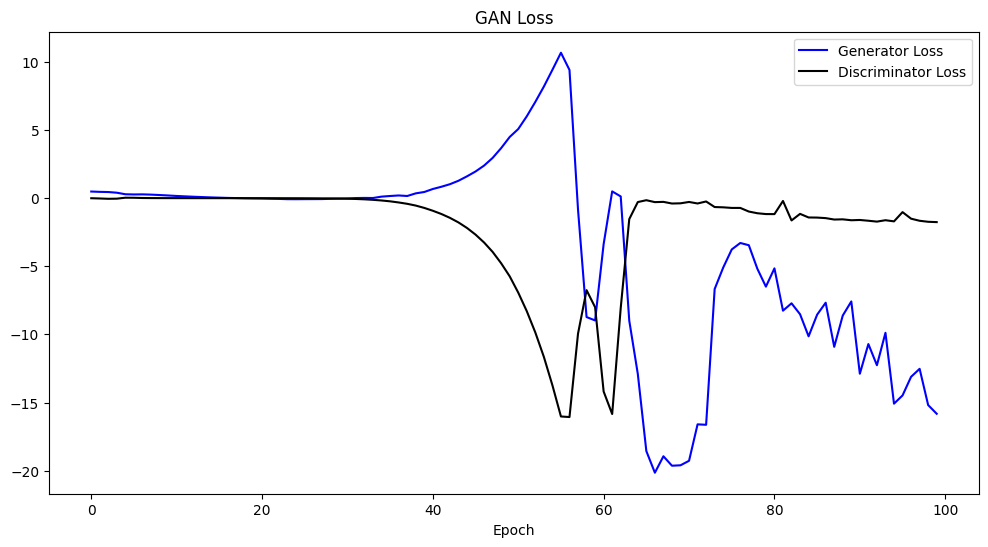

In [19]:
plt.figure(figsize = (12, 6))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('GAN Loss')
plt.xlabel('Epoch')
plt.legend(loc = 'upper right')

In [20]:
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:0.8068566908681745
Coefficient of Determination 0.9810286443259268


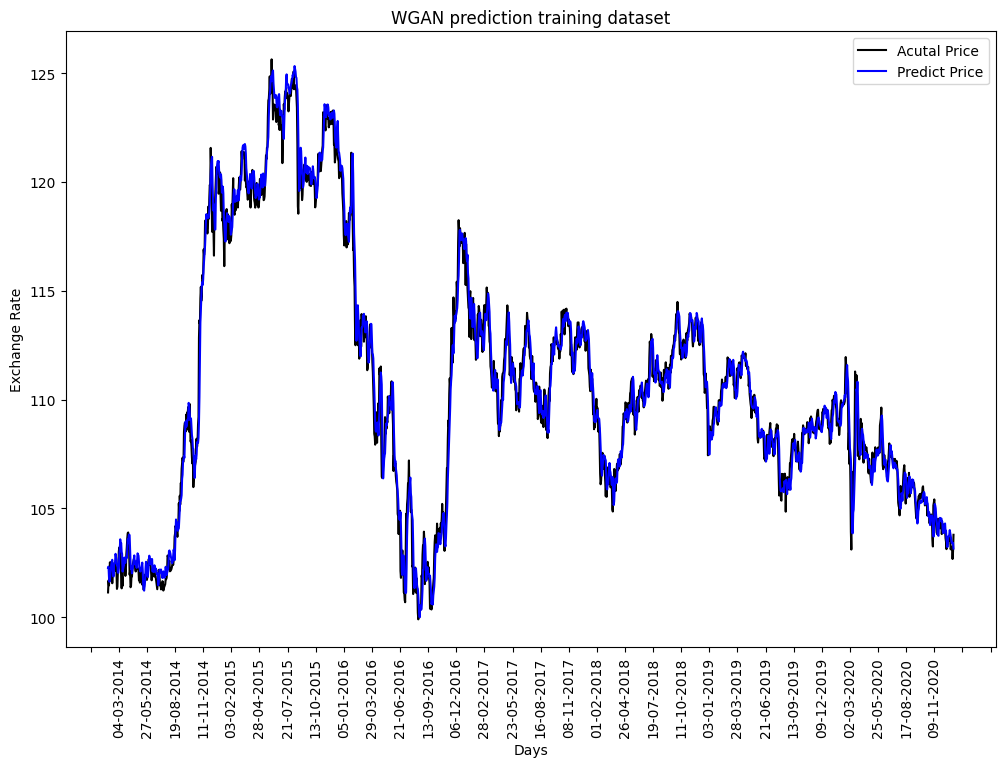

In [21]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Acutal Price')
plt.plot(data[: y_train_pred.shape[0] ].index,y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('WGAN prediction training dataset')
plt.ylabel('Exchange Rate')
plt.xlabel('Days')
plt.legend(loc = 'upper right')
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
plt.xticks(rotation=90)


MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

from sklearn.metrics import r2_score

R_square = r2_score(y_train_true, y_train_pred)
print('Coefficient of Determination', R_square)

In [22]:
print(data[: y_train_pred.shape[0] ].index)

Index(['30-01-2014', '31-01-2014', '03-02-2014', '04-02-2014', '05-02-2014',
       '06-02-2014', '07-02-2014', '10-02-2014', '11-02-2014', '12-02-2014',
       ...
       '23-12-2020', '24-12-2020', '25-12-2020', '28-12-2020', '29-12-2020',
       '30-12-2020', '31-12-2020', '01-01-2021', '04-01-2021', '05-01-2021'],
      dtype='object', name='Date', length=1805)


Test dataset RMSE:1.3548202609685063
Coefficient of Determination 0.9915403045916238


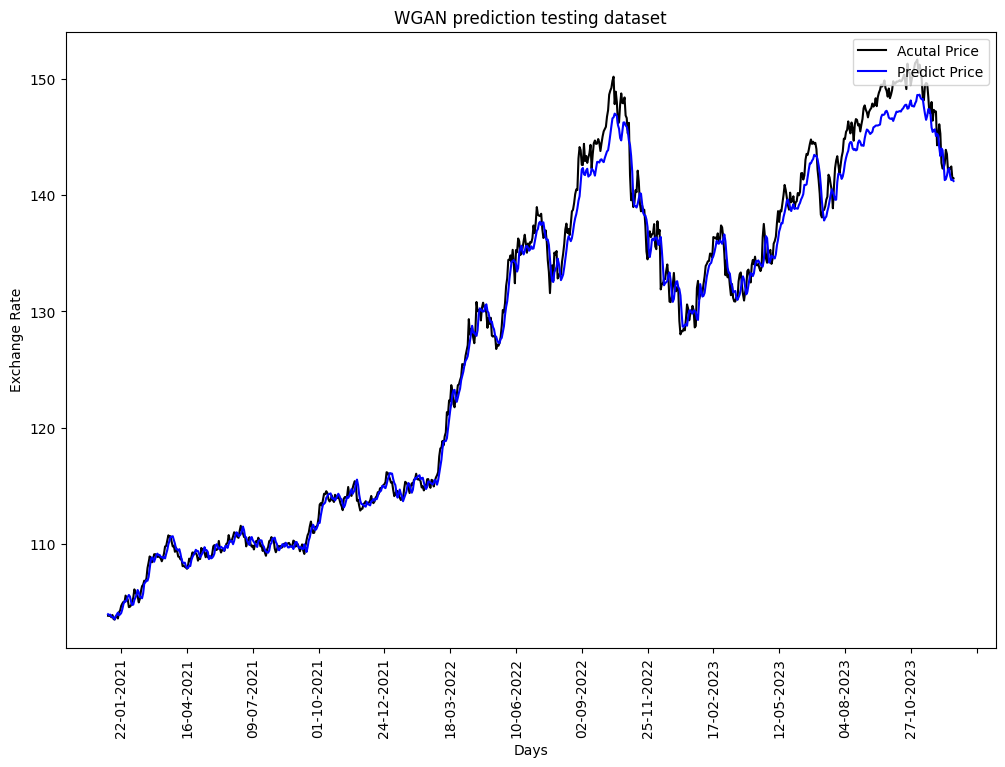

In [24]:
plt.figure(figsize=(12, 8))
#print(data[2069:  ].index)
plt.plot( y_test_true[:], color = 'black', label = 'Acutal Price')
plt.plot( data[y_train_pred.size: y_train_pred.size+y_test_pred.shape[0] ].index,y_test_pred[:], color = 'blue', label = 'Predict Price')
plt.title('WGAN prediction testing dataset')
plt.ylabel('Exchange Rate')
plt.xlabel('Days')
plt.legend(loc = 'upper right')
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
plt.xticks(rotation=90)


MSE = mean_squared_error(y_test_true[:], y_test_pred[:])
RMSE = math.sqrt(MSE)
print(f'Test dataset RMSE:{RMSE}')

from sklearn.metrics import r2_score

R_square = r2_score(y_test_true[:], y_test_pred[:])
print('Coefficient of Determination', R_square)